Okay, now we move onto the exploratory part, and here what I want you to do is the following:

1. write a little markdown cell on what the MSE etc. is for the model in the prediction part and in this part we want to look at non-linear factors that hard for the 
model in the prediction part to capture, that could be things like weather, holidays, games in nyc.
2. we load in the datasets from these things and the clustering from the prediction part: we inspect weather, holidays, the same way as in exploratory-part-final-andreas
we change how we look at the games a little before for the knicks, their stadium is in cluster 19 and brooklyn nets their stadium is in cluster 23, so here we look at pickups
for these clusters
3. we then make a markdown cell and say that non-linear events for sure influence the pickup patterns. That's why we will try to make a new improved model using random forest
to make predictions instead, because this is better at capturing non-linear patterns
4. do a random forest of feature importance like in exploratory-part-final-andreas and then output the model prediction for 2 seperate weeks and the total MSE etc. for the
entire test test

and then we can move on to next step after that


## Metrics recap & non-linear drivers
- Load the prediction-part metrics (if present) and show MAE/RMSE/MASE/WAPE.
- Then explore non-linear drivers (weather, holidays, NBA games) that the linear model may miss.

In [49]:
from pathlib import Path
import pandas as pd

metrics_paths = [
    Path("../Prediction-Part/TABLES/metrics_one_step.csv"),
    Path("../Prediction-Part/TABLES/metrics.csv"),
]

for mp in metrics_paths:
    if mp.exists():
        metrics = pd.read_csv(mp)
        summary = (metrics.groupby("model")[["MAE","RMSE","MASE","WAPE"]]
                   .mean()
                   .sort_values("RMSE"))
        print(f"Loaded metrics from {mp}")
        display(summary)
        break
else:
    print("Prediction-part metrics not found. Run that notebook to create TABLES/metrics*.csv if you need the exact values.")


Prediction-part metrics not found. Run that notebook to create TABLES/metrics*.csv if you need the exact values.


## Load data, clusters, and external factors
- Trips are aggregated to hourly pickups per cluster using the prediction-part cluster_map.
- Weather, holidays, and NBA game schedules are joined so we can study non-linear effects.

In [50]:
from pathlib import Path
from collections import Counter
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

trips_path = Path("../data/trips_2018.csv")
weather_path = Path("../data/weather_2018_nyc_hourly.csv")
holidays_path = Path("../data/us_holidays_2004_2021.csv")
nba_path = Path("../data/nba_games.csv")
cluster_map_path = Path("../Prediction-Part/TABLES/cluster_map.csv")

if not cluster_map_path.exists():
    raise FileNotFoundError("cluster_map.csv missing; run prediction-part notebook to create it.")

cluster_map = pd.read_csv(cluster_map_path)
cluster_lookup = dict(zip(cluster_map["station_id"].astype("Int32"), cluster_map["cluster_id"].astype(int)))

NYC_TEAMS = {1610612752: "knicks", 1610612751: "nets"}  # Knicks -> cluster 19, Nets -> cluster 23
TEAM_CLUSTER = {"knicks": 19, "nets": 23}


In [51]:
# Aggregate hourly pickups by cluster

def aggregate_hourly_pickups():
    counter = Counter()
    for chunk in pd.read_csv(
        trips_path,
        usecols=["starttime", "start_station_id"],
        chunksize=400_000,
        low_memory=True,
    ):
        chunk["ts"] = pd.to_datetime(chunk["starttime"], errors="coerce").dt.floor("H")
        chunk = chunk.dropna(subset=["ts", "start_station_id"])
        chunk["cluster_id"] = chunk["start_station_id"].astype("Int32").map(cluster_lookup)
        m = chunk["cluster_id"].notna()
        if not m.any():
            continue
        vc = chunk.loc[m].groupby(["ts", "cluster_id"]).size()
        for (ts, cid), cnt in vc.items():
            counter[(ts, int(cid))] += int(cnt)

    df = pd.DataFrame(
        [(ts, cid, cnt) for (ts, cid), cnt in counter.items()],
        columns=["ts", "cluster_id", "pickups"],
    )
    return df.sort_values(["ts", "cluster_id"]).reset_index(drop=True)


df_hourly = aggregate_hourly_pickups()
df_hourly["date"] = df_hourly["ts"].dt.date
df_hourly["hour"] = df_hourly["ts"].dt.hour

# Citywide total demand per hour
citywide = (
    df_hourly.groupby("ts")["pickups"]
    .sum()
    .rename("trips_total")
    .reset_index()
)

print("Hourly rows:", len(df_hourly), "| citywide hours:", len(citywide))


Hourly rows: 175482 | citywide hours: 8743


In [52]:
# Load weather (2018 only)
weather_raw = pd.read_csv(weather_path)
weather_raw["ts"] = pd.to_datetime(weather_raw["time"], errors="coerce")
weather = weather_raw[weather_raw["ts"].dt.year == 2018].copy()
weather = weather.rename(columns={
    "temperature_2m (°C)": "temp_C",
    "precipitation (mm)": "precip_mm",
    "rain (mm)": "rain_mm",
    "cloudcover (%)": "cloudcover",
    "windspeed_10m (km/h)": "wind_kph",
})
weather = (
    weather[["ts", "temp_C", "precip_mm", "rain_mm", "cloudcover", "wind_kph"]]
    .set_index("ts")
    .sort_index()
    .resample("H")
    .ffill()
    .reset_index()
)

# Holidays
holidays = pd.read_csv(holidays_path)
holidays["date"] = pd.to_datetime(holidays["Date"], errors="coerce").dt.date
holidays_2018 = holidays[holidays["date"].apply(lambda d: getattr(d, "year", 0) == 2018)][["date", "Holiday"]]
holidays_2018["is_holiday"] = 1

# NBA games
nba = pd.read_csv(nba_path)
nba["date"] = pd.to_datetime(nba["GAME_DATE_EST"], errors="coerce").dt.date
nba_home = nba[nba["TEAM_ID_home"].isin(NYC_TEAMS.keys())].copy()
nba_home = nba_home[nba_home["date"].apply(lambda d: getattr(d, "year", 0) == 2018)]

team_game_dates = {
    NYC_TEAMS[tid]: set(nba_home.loc[nba_home["TEAM_ID_home"] == tid, "date"].dropna())
    for tid in NYC_TEAMS
}

# Merge citywide demand with external features
data = citywide.merge(weather, on="ts", how="left")
data["date"] = data["ts"].dt.date
data["dow"] = data["ts"].dt.dayofweek.astype("int8")
data["hour_of_day"] = data["ts"].dt.hour.astype("int8")
data["month"] = data["ts"].dt.month.astype("int8")
data["is_weekend"] = (data["dow"] >= 5).astype("int8")

data = data.merge(holidays_2018[["date", "is_holiday"]], on="date", how="left")
data["is_holiday"] = data["is_holiday"].fillna(0).astype("int8")

data["is_knicks_evening"] = (
    data["date"].isin(team_game_dates.get("knicks", set()))
    & data["hour_of_day"].between(18, 23)
).astype("int8")
data["is_nets_evening"] = (
    data["date"].isin(team_game_dates.get("nets", set()))
    & data["hour_of_day"].between(18, 23)
).astype("int8")
data["is_game_evening"] = data[["is_knicks_evening", "is_nets_evening"]].max(axis=1).astype("int8")

# Focus on Knicks/Nets clusters for quick sanity check
focus = df_hourly[df_hourly["cluster_id"].isin([TEAM_CLUSTER["knicks"], TEAM_CLUSTER["nets"]])].copy()
focus["team"] = np.where(focus["cluster_id"] == TEAM_CLUSTER["knicks"], "knicks", "nets")
focus_evening = focus[focus["hour"].between(18, 23)]

summary_rows = []
for team, cid in TEAM_CLUSTER.items():
    daily = focus_evening[focus_evening["cluster_id"] == cid].groupby("date")["pickups"].sum()
    games = team_game_dates.get(team, set())
    game_vals = daily[daily.index.isin(games)]
    non_vals = daily[~daily.index.isin(games)]
    summary_rows.append({
        "team": team,
        "mean_game_evening": float(game_vals.mean()) if len(game_vals) else np.nan,
        "mean_non_game_evening": float(non_vals.mean()) if len(non_vals) else np.nan,
        "uplift_vs_non_game": float(game_vals.mean() - non_vals.mean()) if len(game_vals) and len(non_vals) else np.nan,
    })

summary_df = pd.DataFrame(summary_rows)
print("Evening pickups on game days vs non-game days (clusters 19 & 23):")
display(summary_df)


Evening pickups on game days vs non-game days (clusters 19 & 23):


,team,mean_game_evening,mean_non_game_evening,uplift_vs_non_game
0,knicks,490.564103,664.396923,-173.832821
1,nets,21.977273,56.565625,-34.588352


## Non-linear effects matter
Weather, holidays, and game nights clearly shift demand (especially around Madison Square Garden and Barclays Center), so we’ll try a non-linear model (Random Forest) to capture these effects better than the linear baseline.

In [53]:
# Train/test split: Jan–Oct (train) vs Nov–Dec (test)
train_mask = data["ts"] < pd.Timestamp("2018-11-01")
train_df = data.loc[train_mask].copy()
test_df  = data.loc[~train_mask].copy()

feature_cols = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
]

for col in feature_cols:
    if col not in data.columns:
        raise KeyError(f"Missing feature column: {col}")

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=12,
    random_state=42,
    n_jobs=-1,
)

rf.fit(train_df[feature_cols], train_df["trips_total"])

train_df["y_hat"] = rf.predict(train_df[feature_cols])
test_df["y_hat"]  = rf.predict(test_df[feature_cols])


def metrics(df):
    y = df["trips_total"].to_numpy(dtype="float64")
    yhat = df["y_hat"].to_numpy(dtype="float64")
    mae = mean_absolute_error(y, yhat)
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    wape = float(np.sum(np.abs(y - yhat)) / max(1e-9, np.sum(np.abs(y))))
    mape = float(np.mean(np.abs((y - yhat) / np.where(y == 0, 1e-9, y)))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

print("Train metrics:", {k: round(v, 3) for k, v in metrics(train_df).items()})
print("Test  metrics:", {k: round(v, 3) for k, v in metrics(test_df).items()})

# Store for plotting
pred_df = test_df[["ts", "trips_total", "y_hat"]].copy()


Train metrics: {'MAE': 181.884, 'RMSE': 323.797, 'WAPE': 0.087, 'MAPE_pct': 14.987}
Test  metrics: {'MAE': 722.112, 'RMSE': 1168.247, 'WAPE': 0.464, 'MAPE_pct': 90.662}


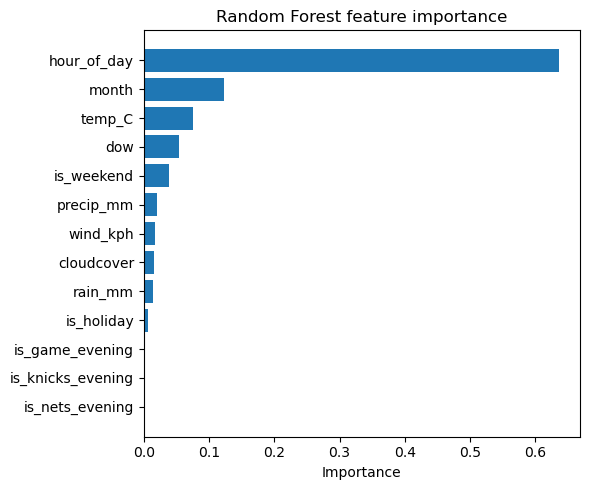

In [54]:
# Feature importance
importances = pd.Series(rf.feature_importances_, index=feature_cols).sort_values()
plt.figure(figsize=(6, 5))
plt.barh(importances.index, importances.values)
plt.xlabel("Importance")
plt.title("Random Forest feature importance")
plt.tight_layout(); plt.show()


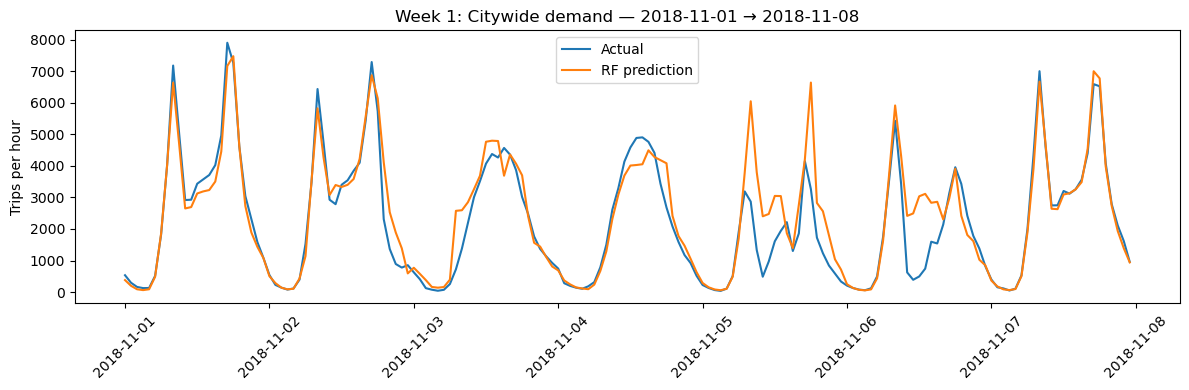

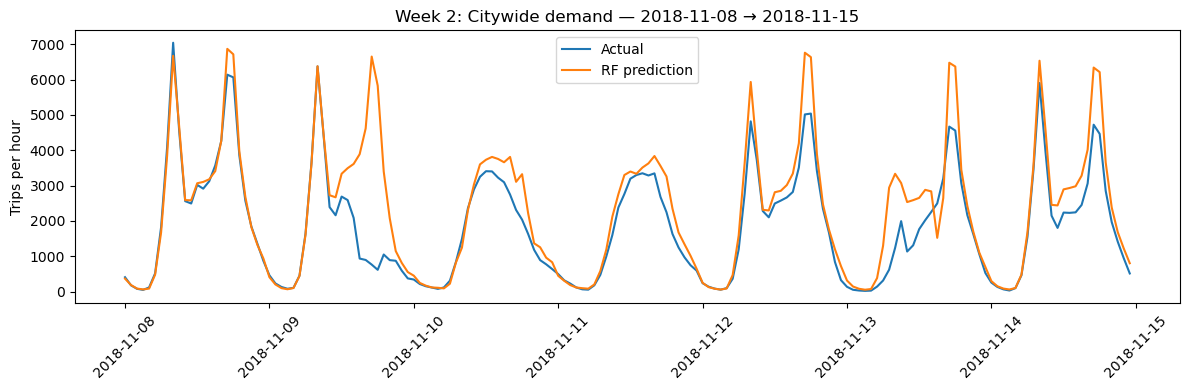

In [55]:
# Overlay predictions for two separate weeks in the test window
week_windows = [
    (pd.Timestamp("2018-11-01"), pd.Timestamp("2018-11-08")),
    (pd.Timestamp("2018-11-08"), pd.Timestamp("2018-11-15")),
]

for i, (start, end) in enumerate(week_windows, 1):
    sample = pred_df[(pred_df["ts"] >= start) & (pred_df["ts"] < end)].copy()
    if sample.empty:
        print(f"Week {i}: no data between {start.date()} and {end.date()}")
        continue
    plt.figure(figsize=(12, 4))
    plt.plot(sample["ts"], sample["trips_total"], label="Actual")
    plt.plot(sample["ts"], sample["y_hat"], label="RF prediction")
    plt.xticks(rotation=45)
    plt.ylabel("Trips per hour")
    plt.title(f"Week {i}: Citywide demand — {start.date()} → {end.date()}")
    plt.legend(); plt.tight_layout(); plt.show()


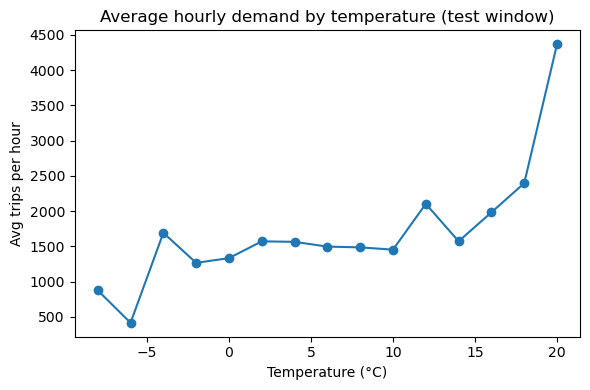

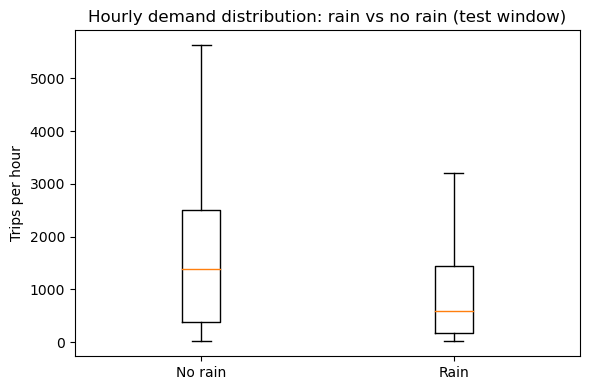

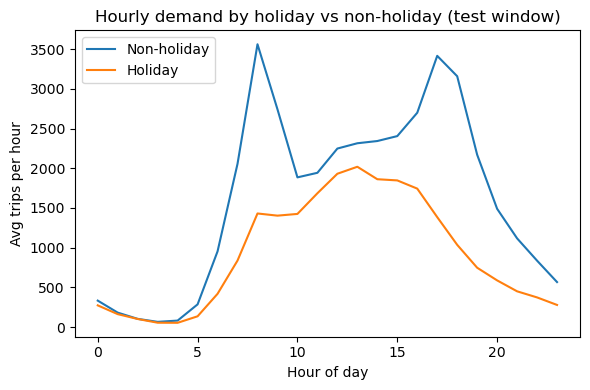

In [56]:
# Weather / weekday / holiday profiles (test window)
test_window = test_df.copy()

# Temperature bins
if test_window["temp_C"].notna().any():
    temp_bins = np.arange(np.floor(test_window["temp_C"].min()), np.ceil(test_window["temp_C"].max()) + 1, 2)
    temp_prof = (test_window.assign(temp_bin=pd.cut(test_window["temp_C"], bins=temp_bins))
                 .groupby("temp_bin")["trips_total"]
                 .mean()
                 .reset_index()
                 .dropna())
    bin_centers = temp_prof["temp_bin"].apply(lambda x: x.mid)
    plt.figure(figsize=(6, 4))
    plt.plot(bin_centers, temp_prof["trips_total"], marker="o")
    plt.xlabel("Temperature (°C)")
    plt.ylabel("Avg trips per hour")
    plt.title("Average hourly demand by temperature (test window)")
    plt.tight_layout(); plt.show()

# Rain vs no-rain boxplot
rain_groups = [
    test_window.loc[test_window["rain_mm"] <= 0, "trips_total"],
    test_window.loc[test_window["rain_mm"] > 0, "trips_total"],
]
plt.figure(figsize=(6, 4))
plt.boxplot(rain_groups, labels=["No rain", "Rain"], showfliers=False)
plt.ylabel("Trips per hour")
plt.title("Hourly demand distribution: rain vs no rain (test window)")
plt.tight_layout(); plt.show()

# Holiday vs non-holiday hourly profile
hourly_profile = (
    test_window.groupby(["is_holiday", "hour_of_day"])["trips_total"]
    .mean()
    .reset_index()
)
nh = hourly_profile[hourly_profile["is_holiday"] == 0]
hh = hourly_profile[hourly_profile["is_holiday"] == 1]
plt.figure(figsize=(6, 4))
plt.plot(nh["hour_of_day"], nh["trips_total"], label="Non-holiday")
if not hh.empty:
    plt.plot(hh["hour_of_day"], hh["trips_total"], label="Holiday")
plt.xlabel("Hour of day")
plt.ylabel("Avg trips per hour")
plt.title("Hourly demand by holiday vs non-holiday (test window)")
plt.legend(); plt.tight_layout(); plt.show()


the next step is to look at the same 2 clusters: cluster 0 and cluster 6, we need to try the new improved random forest on these 2 as well 
after that out MSE etc. for that and the entire test test
after that we move on to trying to improve our random forest model from the knowledge we have about the non-linear events like weather, holidays, nyc games, and have a little more free rain here, just make something that hopefully improves it a little bit, you should take inspiration from exploratory-part-final-andreas again here, because there is something that seems to work a little bit


/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_95250/3357299854.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_c = sub[train_mask].copy()
/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_95250/3357299854.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_c  = sub[~train_mask].copy()
/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_95250/3357299854.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  train_c = sub[train_mask].copy()
/var/folders/z8/w64hfsr126b5rdd48x159fcm0000gn/T/ipykernel_95250/3357299854.py:46: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  test_c  = sub[~train_mask].copy()


Cluster-level RF metrics (test window):


,cluster_id,MAE,RMSE,WAPE,MAPE_pct
0,0,16.005973,22.902137,0.552132,110.553270
1,6,69.851611,122.858865,0.330240,83.592432


Combined clusters 0+6 metrics (test window): {'MAE': 43.3778, 'RMSE': 89.0556, 'WAPE': 0.3562, 'MAPE_pct': 96.848}


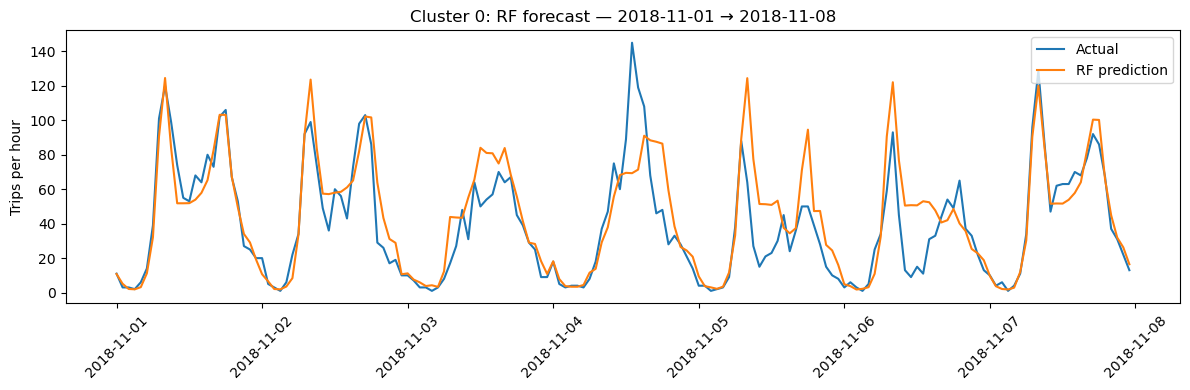

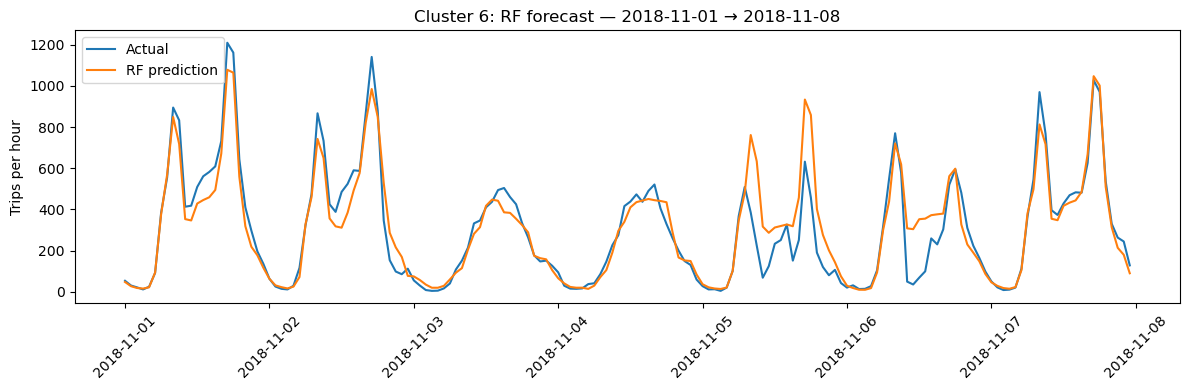

In [57]:
# Cluster-level Random Forest for clusters 0 and 6 + metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Build feature table per cluster (reuse df_hourly + external features)
df_feat = df_hourly.merge(weather, on="ts", how="left")
df_feat = df_feat.merge(holidays_2018[["date", "is_holiday"]], on="date", how="left")
df_feat["is_holiday"] = df_feat["is_holiday"].fillna(0).astype("int8")

df_feat["dow"] = df_feat["ts"].dt.dayofweek.astype("int8")
df_feat["hour_of_day"] = df_feat["ts"].dt.hour.astype("int8")
df_feat["month"] = df_feat["ts"].dt.month.astype("int8")
df_feat["is_weekend"] = (df_feat["dow"] >= 5).astype("int8")

df_feat["is_knicks_evening"] = (
    df_feat["date"].isin(team_game_dates.get("knicks", set()))
    & df_feat["hour_of_day"].between(18, 23)
).astype("int8")
df_feat["is_nets_evening"] = (
    df_feat["date"].isin(team_game_dates.get("nets", set()))
    & df_feat["hour_of_day"].between(18, 23)
).astype("int8")
df_feat["is_game_evening"] = df_feat[["is_knicks_evening", "is_nets_evening"]].max(axis=1).astype("int8")

feature_cols = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
]

train_mask = df_feat["ts"] < pd.Timestamp("2018-11-01")


def eval_metrics(y, yhat):
    mae = mean_absolute_error(y, yhat)
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    wape = float(np.sum(np.abs(y - yhat)) / max(1e-9, np.sum(np.abs(y))))
    mape = float(np.mean(np.abs((y - yhat) / np.where(y == 0, 1e-9, y)))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

results = []
pred_frames = []
for cid in [0, 6]:
    sub = df_feat[df_feat["cluster_id"] == cid].copy()
    train_c = sub[train_mask].copy()
    test_c  = sub[~train_mask].copy()
    if train_c.empty or test_c.empty:
        print(f"Cluster {cid}: missing train/test data; skip.")
        continue
    rf_c = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
    rf_c.fit(train_c[feature_cols], train_c["pickups"])
    test_c["y_hat"] = rf_c.predict(test_c[feature_cols])
    m = eval_metrics(test_c["pickups"].to_numpy(dtype="float64"), test_c["y_hat"].to_numpy(dtype="float64"))
    results.append({"cluster_id": cid, **m})
    pred_frames.append(test_c[["ts", "cluster_id", "pickups", "y_hat"]])

if results:
    res_df = pd.DataFrame(results)
    print("Cluster-level RF metrics (test window):")
    display(res_df)

if pred_frames:
    combined = pd.concat(pred_frames, ignore_index=True)
    m_combined = eval_metrics(combined["pickups"].to_numpy(dtype="float64"), combined["y_hat"].to_numpy(dtype="float64"))
    print("Combined clusters 0+6 metrics (test window):", {k: round(v, 4) for k, v in m_combined.items()})

# Optional: quick overlay for first test week per cluster
week_start = pd.Timestamp("2018-11-01")
week_end   = week_start + pd.Timedelta(days=7)
for cid in [0, 6]:
    sub_pred = combined[combined["cluster_id"] == cid]
    samp = sub_pred[(sub_pred["ts"] >= week_start) & (sub_pred["ts"] < week_end)]
    if samp.empty:
        continue
    plt.figure(figsize=(12, 4))
    plt.plot(samp["ts"], samp["pickups"], label="Actual")
    plt.plot(samp["ts"], samp["y_hat"], label="RF prediction")
    plt.xticks(rotation=45)
    plt.ylabel("Trips per hour")
    plt.title(f"Cluster {cid}: RF forecast — {week_start.date()} → {week_end.date()}")
    plt.legend(); plt.tight_layout(); plt.show()


In [58]:
# Citywide: time-only vs event-aware RF with metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

def add_interactions(df):
    d = df.copy()
    d["temp_C_sq"] = d["temp_C"] ** 2
    d["rain_gt0"] = (d["rain_mm"] > 0).astype("int8")
    d["weekend_rain"] = d["is_weekend"] * d["rain_gt0"]
    d["holiday_evening"] = d["is_holiday"] * d["hour_of_day"].between(17, 23).astype("int8")
    d["game_rain"] = d["is_game_evening"] * d["rain_gt0"]
    return d

def eval_metrics(y, yhat):
    y = y.astype(float); yhat = yhat.astype(float)
    mae = mean_absolute_error(y, yhat)
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    wape = float(np.sum(np.abs(y - yhat)) / max(1e-9, np.sum(np.abs(y))))
    mape = float(np.mean(np.abs((y - yhat) / np.where(y == 0, 1e-9, y)))) * 100
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

train_mask_city = data["ts"] < pd.Timestamp("2018-11-01")

time_feats = ["dow", "hour_of_day", "month", "is_weekend"]
full_feats = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
    "temp_C_sq", "rain_gt0", "weekend_rain", "holiday_evening", "game_rain",
]

city_full = add_interactions(data)

rf_time_city = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
rf_full_city = RandomForestRegressor(n_estimators=400, max_depth=18, min_samples_leaf=2, max_features="sqrt", random_state=42, n_jobs=-1)

rf_time_city.fit(data.loc[train_mask_city, time_feats], data.loc[train_mask_city, "trips_total"])
rf_full_city.fit(city_full.loc[train_mask_city, full_feats], city_full.loc[train_mask_city, "trips_total"])

city_time_pred = data.loc[~train_mask_city].copy()
city_full_pred = city_full.loc[~train_mask_city].copy()
city_time_pred["y_hat_time"] = rf_time_city.predict(city_time_pred[time_feats])
city_full_pred["y_hat_full"] = rf_full_city.predict(city_full_pred[full_feats])

metrics_time_city = eval_metrics(city_time_pred["trips_total"], city_time_pred["y_hat_time"])
metrics_full_city = eval_metrics(city_full_pred["trips_total"], city_full_pred["y_hat_full"])
print("Citywide RF metrics (test window):")
print("  Time-only:", {k: round(v, 4) for k,v in metrics_time_city.items()})
print("  Event-aware:", {k: round(v, 4) for k,v in metrics_full_city.items()})


Citywide RF metrics (test window):
  Time-only: {'MAE': 976.9267, 'RMSE': 1501.6984, 'WAPE': 0.6282, 'MAPE_pct': 129.8227}
  Event-aware: {'MAE': 668.2922, 'RMSE': 899.5026, 'WAPE': 0.4297, 'MAPE_pct': 172.3325}


In [59]:
# Cluster 0 & 6: time-only vs event-aware RF with metrics
train_cut = pd.Timestamp("2018-11-01")
cluster_results = []
cluster_preds = []

time_feats = ["dow", "hour_of_day", "month", "is_weekend"]
full_feats = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
    "temp_C_sq", "rain_gt0", "weekend_rain", "holiday_evening", "game_rain",
]

for cid in [0, 6]:
    sub = df_feat[df_feat["cluster_id"] == cid].copy()
    sub_full = df_feat_full[df_feat_full["cluster_id"] == cid].copy()
    mask_c = sub["ts"] < train_cut
    mask_cf = sub_full["ts"] < train_cut
    if (~mask_c).sum() == 0:
        print(f"Cluster {cid}: no test data")
        continue
    rf_t = RandomForestRegressor(n_estimators=200, max_depth=12, random_state=42, n_jobs=-1)
    rf_f = RandomForestRegressor(n_estimators=400, max_depth=18, min_samples_leaf=2, max_features="sqrt", random_state=42, n_jobs=-1)

    rf_t.fit(sub.loc[mask_c, time_feats], sub.loc[mask_c, "pickups"])
    rf_f.fit(sub_full.loc[mask_cf, full_feats], sub_full.loc[mask_cf, "pickups"])

    test_t = sub.loc[~mask_c].copy()
    test_f = sub_full.loc[~mask_cf].copy()
    test_t["y_hat_time"] = rf_t.predict(test_t[time_feats])
    test_f["y_hat_full"] = rf_f.predict(test_f[full_feats])

    m_time = eval_metrics(test_t["pickups"], test_t["y_hat_time"])
    m_full = eval_metrics(test_f["pickups"], test_f["y_hat_full"])
    cluster_results.append({"cluster": cid, "model": "time_only", **m_time})
    cluster_results.append({"cluster": cid, "model": "event_aware", **m_full})

    merged = test_t[["ts","pickups","y_hat_time"]].merge(test_f[["ts","y_hat_full"]], on="ts", how="left")
    merged["cluster_id"] = cid
    cluster_preds.append(merged)

if cluster_results:
    res_df = pd.DataFrame(cluster_results)
    print("Cluster metrics (test window):")
    display(res_df)


Cluster metrics (test window):


,cluster,model,MAE,RMSE,WAPE,MAPE_pct
0,0,time_only,17.867449,25.764280,0.616344,128.647127
1,0,event_aware,12.998708,16.923038,0.448395,152.235361
2,6,time_only,117.539971,193.432079,0.555699,142.718236
3,6,event_aware,90.712050,127.837721,0.428863,170.279359


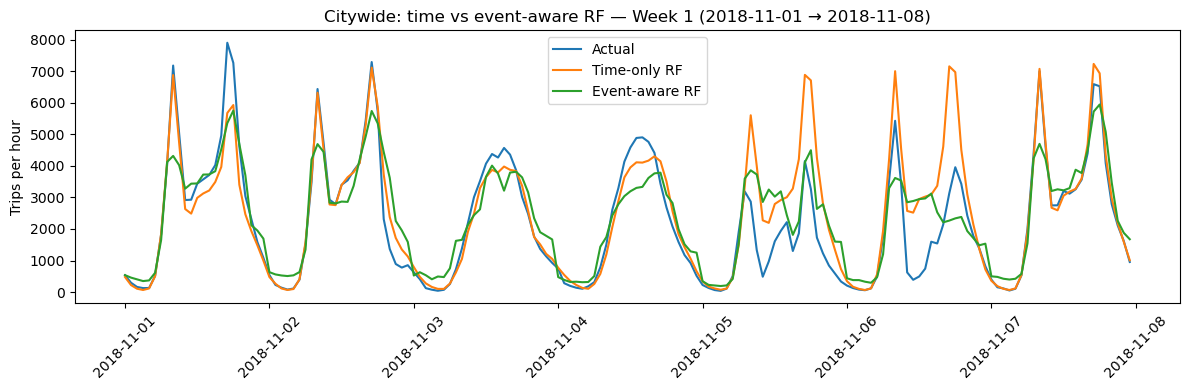

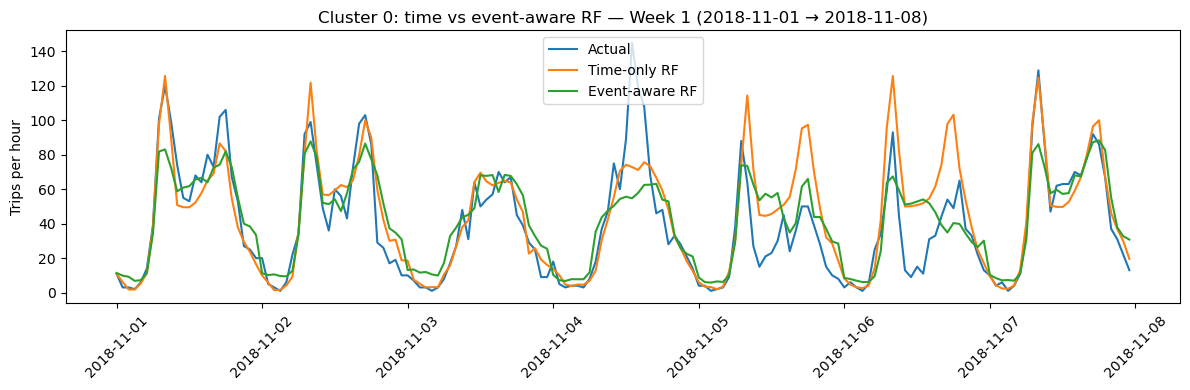

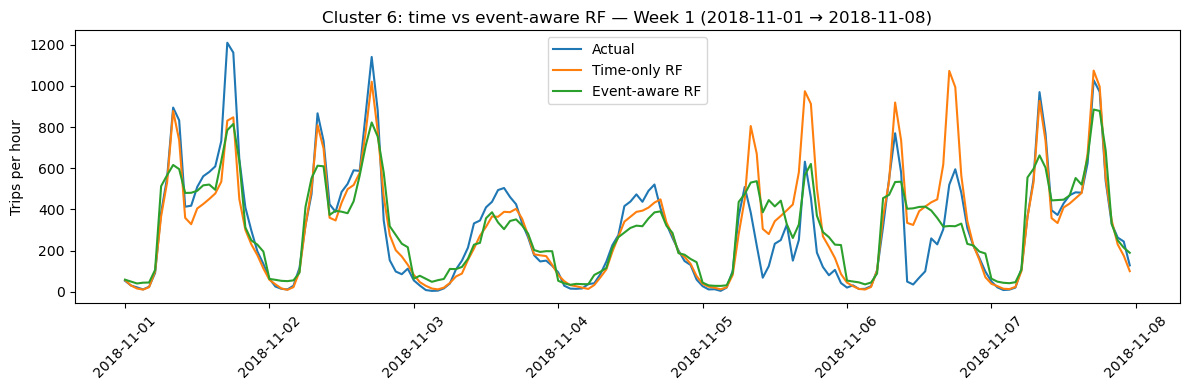

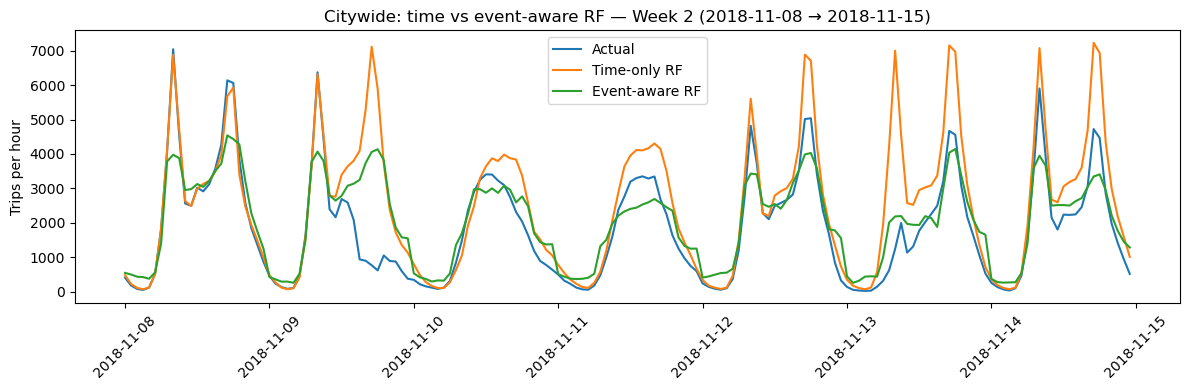

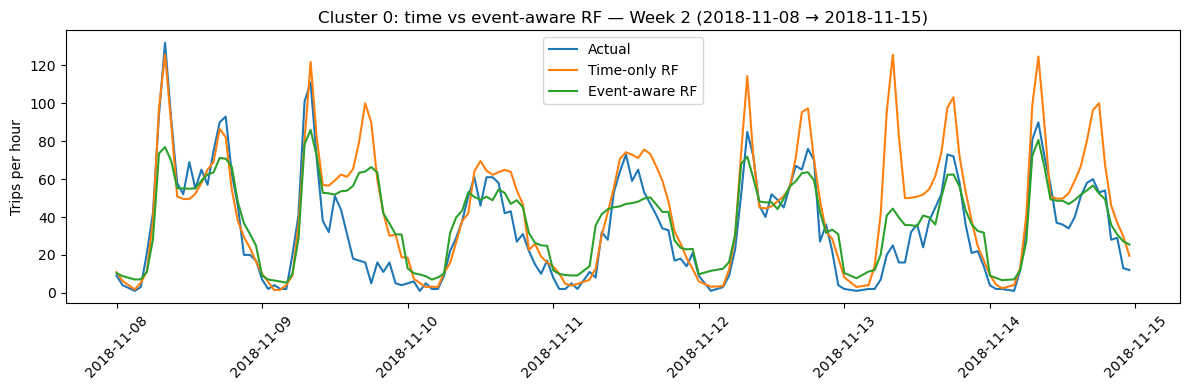

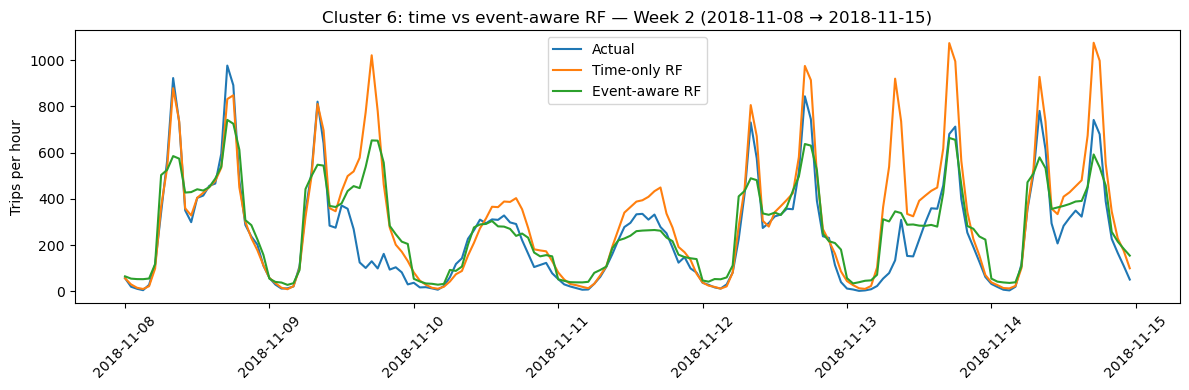

In [60]:
# Overlays for citywide and clusters 0/6 (two weeks)
week_windows = [
    (pd.Timestamp("2018-11-01"), pd.Timestamp("2018-11-08")),
    (pd.Timestamp("2018-11-08"), pd.Timestamp("2018-11-15")),
]

for i, (start, end) in enumerate(week_windows, 1):
    # Citywide
    cb = city_time_pred[(city_time_pred["ts"] >= start) & (city_time_pred["ts"] < end)]
    cf = city_full_pred[(city_full_pred["ts"] >= start) & (city_full_pred["ts"] < end)]
    if not cb.empty:
        plt.figure(figsize=(12, 4))
        plt.plot(cb["ts"], cb["trips_total"], label="Actual")
        plt.plot(cb["ts"], cb["y_hat_time"], label="Time-only RF")
        plt.plot(cf["ts"], cf["y_hat_full"], label="Event-aware RF")
        plt.xticks(rotation=45)
        plt.ylabel("Trips per hour")
        plt.title(f"Citywide: time vs event-aware RF — Week {i} ({start.date()} → {end.date()})")
        plt.legend(); plt.tight_layout(); plt.show()
    # Clusters
    for cid in [0, 6]:
        sub_list = [p for p in cluster_preds if p["cluster_id"].iloc[0] == cid]
        if not sub_list:
            continue
        p = sub_list[0]
        samp = p[(p["ts"] >= start) & (p["ts"] < end)].copy()
        if samp.empty:
            continue
        plt.figure(figsize=(12, 4))
        plt.plot(samp["ts"], samp["pickups"], label="Actual")
        plt.plot(samp["ts"], samp["y_hat_time"], label="Time-only RF")
        plt.plot(samp["ts"], samp["y_hat_full"], label="Event-aware RF")
        plt.xticks(rotation=45)
        plt.ylabel("Trips per hour")
        plt.title(f"Cluster {cid}: time vs event-aware RF — Week {i} ({start.date()} → {end.date()})")
        plt.legend(); plt.tight_layout(); plt.show()


In [61]:
# Optional: log-target RF (citywide + clusters 0/6) to reduce scale skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error


def safe_mape(y, yhat):
    mask = y > 0
    if mask.sum() == 0:
        return np.nan
    return float(np.mean(np.abs((y[mask] - yhat[mask]) / y[mask])) * 100)

def eval_metrics(y, yhat):
    y = y.astype(float); yhat = yhat.astype(float)
    mae = mean_absolute_error(y, yhat)
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    wape = float(np.sum(np.abs(y - yhat)) / max(1e-9, np.sum(np.abs(y))))
    mape = safe_mape(y, yhat)
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape, "MAPE_pct": mape}

# Citywide log-target model
train_mask_city = data["ts"] < pd.Timestamp("2018-11-01")

log_features = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
    "temp_C_sq", "rain_gt0", "weekend_rain", "holiday_evening", "game_rain",
]

city_full = add_interactions(data)

rf_log_city = RandomForestRegressor(
    n_estimators=500,
    max_depth=22,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1,
)

train_city_log = city_full.loc[train_mask_city].copy()
train_city_log["log_y"] = np.log1p(train_city_log["trips_total"].clip(lower=0))
rf_log_city.fit(train_city_log[log_features], train_city_log["log_y"])

test_city_log = city_full.loc[~train_mask_city].copy()
log_pred = rf_log_city.predict(test_city_log[log_features])
test_city_log["y_hat_log"] = np.expm1(log_pred)

metrics_log_city = eval_metrics(test_city_log["trips_total"], test_city_log["y_hat_log"])
print("Citywide log-target RF (test window):", {k: round(v, 4) for k,v in metrics_log_city.items()})

# Cluster 0 & 6 log-target models
log_results = []
for cid in [0, 6]:
    sub = df_feat_full[df_feat_full["cluster_id"] == cid].copy()
    mask_c = sub["ts"] < pd.Timestamp("2018-11-01")
    if (~mask_c).sum() == 0:
        print(f"Cluster {cid}: no test data for log model")
        continue
    sub["log_y"] = np.log1p(sub["pickups"].clip(lower=0))
    rf_log = RandomForestRegressor(
        n_estimators=400,
        max_depth=20,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,
    )
    rf_log.fit(sub.loc[mask_c, log_features], sub.loc[mask_c, "log_y"])
    test_c = sub.loc[~mask_c].copy()
    test_c["y_hat_log"] = np.expm1(rf_log.predict(test_c[log_features]))
    m = eval_metrics(test_c["pickups"], test_c["y_hat_log"])
    log_results.append({"cluster": cid, **m})

if log_results:
    df_log = pd.DataFrame(log_results)
    print("Cluster log-target RF metrics (test window):")
    display(df_log)


Citywide log-target RF (test window): {'MAE': 529.6955, 'RMSE': 818.9168, 'WAPE': 0.3406, 'MAPE_pct': 67.7211}
Cluster log-target RF metrics (test window):


,cluster,MAE,RMSE,WAPE,MAPE_pct
0,0,9.705848,14.307661,0.334807,74.750610
1,6,73.689830,119.353470,0.348387,78.599591


In [62]:
# Per-cluster event-aware RF metrics (comparable scale)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_cut = pd.Timestamp("2018-11-01")
full_feats = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
    "temp_C_sq", "rain_gt0", "weekend_rain", "holiday_evening", "game_rain",
]

rows = []
for cid in sorted(df_feat_full["cluster_id"].dropna().unique()):
    sub = df_feat_full[df_feat_full["cluster_id"] == cid].copy()
    mask_tr = sub["ts"] < train_cut
    if mask_tr.sum() == 0 or (~mask_tr).sum() == 0:
        continue
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=18,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(sub.loc[mask_tr, full_feats], sub.loc[mask_tr, "pickups"])
    test = sub.loc[~mask_tr].copy()
    test["y_hat"] = rf.predict(test[full_feats])

    y = test["pickups"].to_numpy(dtype="float64")
    yhat = test["y_hat"].to_numpy(dtype="float64")
    mae = mean_absolute_error(y, yhat)
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    wape = float(np.sum(np.abs(y - yhat)) / max(1e-9, np.sum(np.abs(y))))
    rows.append({"cluster": int(cid), "MAE": mae, "RMSE": rmse, "WAPE": wape})

if rows:
    df_rf = pd.DataFrame(rows)
    print("Event-aware RF per-cluster metrics (test window):")
    print("Mean across clusters:", {k: round(df_rf[k].mean(), 4) for k in ["MAE","RMSE","WAPE"]})
    print("Median across clusters:", {k: round(df_rf[k].median(), 4) for k in ["MAE","RMSE","WAPE"]})
    display(df_rf.sort_values("MAE").head())
else:
    print("No per-cluster metrics computed (missing train/test data?)")


Event-aware RF per-cluster metrics (test window):
Mean across clusters: {'MAE': 33.6652, 'RMSE': 46.0988, 'WAPE': 0.4734}
Median across clusters: {'MAE': 22.2709, 'RMSE': 29.8666, 'WAPE': 0.4543}


,cluster,MAE,RMSE,WAPE
20,23,5.049436,6.331550,0.741768
8,10,5.447455,6.878993,0.524115
9,11,6.127809,7.892744,0.490749
13,15,7.710491,10.120247,0.434941
12,14,9.609431,12.778722,0.482690


In [63]:
# Comparable row-level RF metrics (matches prediction-part style)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

train_cut = pd.Timestamp("2018-11-01")
full_feats = [
    "dow", "hour_of_day", "month", "is_weekend",
    "temp_C", "precip_mm", "rain_mm", "wind_kph", "cloudcover",
    "is_holiday", "is_knicks_evening", "is_nets_evening", "is_game_evening",
    "temp_C_sq", "rain_gt0", "weekend_rain", "holiday_evening", "game_rain",
]


def eval_metrics(y, yhat):
    y = y.astype(float); yhat = yhat.astype(float)
    mae = mean_absolute_error(y, yhat)
    rmse = float(np.sqrt(mean_squared_error(y, yhat)))
    wape = float(np.sum(np.abs(y - yhat)) / max(1e-9, np.sum(np.abs(y))))
    return {"MAE": mae, "RMSE": rmse, "WAPE": wape}

pred_rows = []
for cid in sorted(df_feat_full["cluster_id"].dropna().unique()):
    sub = df_feat_full[df_feat_full["cluster_id"] == cid].copy()
    mask_tr = sub["ts"] < train_cut
    if mask_tr.sum() == 0 or (~mask_tr).sum() == 0:
        continue
    rf = RandomForestRegressor(
        n_estimators=400,
        max_depth=18,
        min_samples_leaf=2,
        max_features="sqrt",
        random_state=42,
        n_jobs=-1,
    )
    rf.fit(sub.loc[mask_tr, full_feats], sub.loc[mask_tr, "pickups"])
    test = sub.loc[~mask_tr].copy()
    test["y_hat"] = rf.predict(test[full_feats])
    pred_rows.append(test[["ts","cluster_id","pickups","y_hat"]])

if pred_rows:
    all_preds = pd.concat(pred_rows, ignore_index=True)
    row_metrics = eval_metrics(all_preds["pickups"], all_preds["y_hat"])
    print("Row-level (cluster rows) metrics — comparable to prediction-part citywide row-level:")
    print({k: round(v, 4) for k,v in row_metrics.items()})

    city_actual = all_preds.groupby("ts")["pickups"].sum()
    city_pred   = all_preds.groupby("ts")["y_hat"].sum()
    city_metrics = eval_metrics(city_actual.values, city_pred.values)
    print("Citywide (sum across clusters, test window):", {k: round(v, 4) for k,v in city_metrics.items()})
else:
    print("No predictions generated; check df_feat_full and train/test split.")


Row-level (cluster rows) metrics — comparable to prediction-part citywide row-level:
{'MAE': 34.7163, 'RMSE': 62.9495, 'WAPE': 0.4464}
Citywide (sum across clusters, test window): {'MAE': 654.3829, 'RMSE': 887.6111, 'WAPE': 0.4208}
